<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/nlp-with-transformers/blob/main/06_summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

이 노트북을 코랩에서 실행하려면 Pro 버전이 필요할 수 있습니다.

In [1]:
# 코랩을 사용하지 않으면 다음 코드를 주석 처리하세요.
# !git clone https://github.com/rickiepark/nlp-with-transformers.git
# %cd nlp-with-transformers
# from install import *
# install_requirements(chapter=6)

In [1]:
from transformers import pipeline, set_seed

# 요약

## CNN/DailyMail 데이터셋

In [2]:
from datasets import load_dataset

dataset = load_dataset("cnn_dailymail", "3.0.0")
print(dataset["train"][0])


train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

C:\Users\kikim\anaconda3\envs\nlp\lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\kikim\.cache\huggingface\hub\datasets--cnn_dailymail. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

{'article': 'LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won\'t cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don\'t plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don\'t think I\'ll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office char

In [3]:
sample = dataset["train"][1]
print(f"""기사 (500개 문자 발췌, 총 길이: {len(sample["article"])}):""")
print(sample["article"][:500])
print(f'\n요약 (길이: {len(sample["highlights"])}):')
print(sample["highlights"])

기사 (500개 문자 발췌, 총 길이: 4051):
Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most s

요약 (길이: 281):
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .


dataset 구조는 기사 원문에 해당하는 article과 기사 요약에 해당하는 highlights로 구성되어있음

In [9]:
sample

{'article': 'Editor\'s note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O\'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most severe mental illnesses are incarcerated until they\'re ready to appear in court. Most often, they face drug charges or charges of assaulting an officer --charges that Judge Steven Leifman says are usually "avoidable felonies." He says the arrests often result from confrontations with police. Mentally ill people often won\'t do what they\'re told when police arrive on the scene -- confrontation seems to exacerbate their illness and they become more paranoid, delusional, and less li

## 텍스트 요약 파이프라인

In [4]:
sample_text = dataset["train"][1]["article"][:2000]
# 딕셔너리에 각 모델이 생성한 요약을 저장합니다.
summaries = {}

In [5]:
import nltk
from nltk.tokenize import sent_tokenize

nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kikim\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
string = "The U.S. are a country. The U.N. is an organization."
sent_tokenize(string)

['The U.S. are a country.', 'The U.N. is an organization.']

### 요약 기준 모델

In [7]:
def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3]) # 문장 단위로 쪼개주는 punkt를 이용하여 앞에 3개 문장만 추출하는 메소드

In [8]:
summaries["baseline"] = three_sentence_summary(sample_text)

In [9]:
summaries

{'baseline': 'Editor\'s note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events.\nHere, Soledad O\'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial.\nMIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."'}

### GPT-2

In [10]:
from transformers import pipeline, set_seed

set_seed(42)

# 코랩의 경우 gpt2-xl을 사용하면 메모리 부족 에러가 발생합니다.
# 대신 "gpt" 또는 "gpt2-large"로 지정하거나 코랩 프로를 사용하세요.
pipe = pipeline("text-generation", model="gpt2")

gpt2_query = sample_text + "\nTL;DR:\n" # "Too Long; Didn't Read"의 약어로 요약을 요청하는 프롬프트 형식을 만듦 
pipe_out = pipe(gpt2_query, max_length=512, clean_up_tokenization_spaces=True) # 불필요한 공백을 제거해줌 
summaries["gpt2"] = "\n".join(
    sent_tokenize(pipe_out[0]["generated_text"][len(gpt2_query) :])) #pipeout에서 나온 전체 문장 중 모델이 생성한 전체 텍스트 중에서 프롬프트 부분을 제외하고 생성한 부분만 출력

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

C:\Users\kikim\anaconda3\envs\nlp\lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\kikim\.cache\huggingface\hub\models--gpt2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [11]:
summaries["gpt2"]

'\nThe prison in jail that serves the mentally ill is a mental health facility with 12,000 inmates.\nIt was founded by psychiatrist Dr. Daniel M. Dufour, who was born in New Orleans by his parents when he was 12.\nThe prison is not just overcrowded: it has been labeled a death camp.\nAccording to the U.S. Department of Justice, about'

### T5

<img alt="T5" width="700" caption="Diagram of T5's text-to-text framework (courtesy of Colin Raffel); besides translation and summarization, the CoLA (linguistic acceptability) and STSB (semantic similarity) tasks are shown" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter08_t5.png?raw=1" id="T5"/>

🛠️ 주요 작업 유형(Task Types)
T5는 다음과 같은 NLP 태스크에 모두 활용

✅ 텍스트 요약 (Summarization)

✅ 기계 번역 (Translation)

✅ 문장 분류 (Classification)

✅ 문장 유사도 판단 (Regression)

✅ 질문 생성 및 답변 (QA)

✅ 감정 분석 (Sentiment Analysis)

✅ 개체명 인식 (NER) 등

| 항목                        | 설명                                                                   |
| ------------------------- | -------------------------------------------------------------------- |
| 🧩 **Text-to-Text 통일 구조** | 모든 태스크를 "텍스트 → 텍스트"로 통합하여 일관된 학습 구조 제공                               |
| 🗂 **멀티태스크 학습**           | 다양한 태스크를 하나의 모델에서 동시에 학습 가능                                          |
| 🔧 **프롬프트 기반 제어**         | `"summarize:"`, `"translate:"` 등의 명령어로 태스크 제어 가능                     |
| 🧠 **사전학습 + 파인튜닝**        | 대규모 코퍼스 사전학습 후 다양한 태스크에 맞춰 파인튜닝 가능                                   |
| 📐 **확장성**                | `t5-small` → `t5-base` → `t5-large` → `t5-3b` → `t5-11b` 등 다양한 크기 제공 |


In [12]:
pipe = pipeline("summarization", model="t5-small")
pipe_out = pipe(sample_text)
summaries["t5"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

C:\Users\kikim\anaconda3\envs\nlp\lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\kikim\.cache\huggingface\hub\models--t5-small. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Device set to use cpu


### BART

Bart는 encoder에서 손상시킨 문장을 복원하는 방법으로 학습되고, decoder에서 기존 transformer에서 학습 하는것과 같이 autoregressive decoding(token을 순서대로 생성)으로 사전학습을 진행하는 모델  

### 📚 BART의 Pretraining 손상 기법 정리
BART는 다양한 손상(Corruption) 기법을 통해 입력 문장을 변형한 후, 원래 문장을 복원하는 방식으로 사전학습을 수행합니다. 이 과정을 통해 문장의 구조와 의미를 깊이 있게 학습할 수 있습니다.

### 🟩 Token Masking
기존의 BERT 모델처럼 무작위의 토큰들을 마스킹합니다.
마스킹된 토큰이 무엇이었는지를 예측하는 방식으로 학습이 진행됩니다.

### 🟥 Token Deletion
무작위로 선택된 토큰들을 삭제합니다.
마스킹과 달리 삭제된 위치에 대한 정보가 주어지지 않아, 해당 위치를 추정해야 하므로 더 어려운 복원 작업이 요구됩니다.

### 🟨 Sentence Permutation
문장 간의 순서를 섞어 노이즈를 추가합니다.
문맥을 무시한 순서 변경을 통해 문장의 전반적 구조 이해 능력을 학습합니다.

### 🟦 Document Rotation
문서 내에서 임의의 토큰을 선택해 해당 위치를 문장의 시작점으로 만들고, 나머지 토큰들을 재배열합니다.
이는 문서의 시작점을 인지하는 능력을 학습하는 데에 활용됩니다.

### 🟪 Text Infilling
논문에서 가장 성능이 좋았다고 언급된 방식입니다.
Poisson 분포(λ=3)에 따라 span 길이를 결정하고, 해당 span을 통째로 마스킹합니다.
이 방식은 문장 내 연속된 공백을 복원하는 능력을 집중적으로 학습시킵니다.
KoBART 등 일부 파생 모델은 이 방식만을 사용해 학습되기도 했습니다.  

![바트의 손상학습 방법](https://postfiles.pstatic.net/MjAyNDAzMDJfMTc0/MDAxNzA5MzcwMDA3MDA4.407hftle_SMjBPf9iENDX9z98-lFHOp1rCrVYWIVsBIg.IbCZVScL4ykREOBelCPClK5RR4feLcmppcpctQSvQHIg.PNG/image.png?type=w773)



In [13]:
pipe = pipeline("summarization", model="facebook/bart-large-cnn")
pipe_out = pipe(sample_text)
summaries["bart"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

C:\Users\kikim\anaconda3\envs\nlp\lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\kikim\.cache\huggingface\hub\models--facebook--bart-large-cnn. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu


In [14]:
from transformers import pipeline
from nltk.tokenize import sent_tokenize

pipe = pipeline("summarization", model="facebook/bart-base")
pipe_out = pipe(sample_text, max_length=130, min_length=30, do_sample=False)
summaries["bart"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))


config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

C:\Users\kikim\anaconda3\envs\nlp\lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\kikim\.cache\huggingface\hub\models--facebook--bart-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu


### PEGASUS

PEGASUS는 Google에서 개발한 추상적 요약(abstractive summarization) 특화 모델로,
기존의 마스킹 방식 대신 문장 전체를 마스킹(masked gap sentence)하고 그걸 생성하도록 학습

<img alt="pegasus" width="700" caption="Diagram of PEGASUS architecture (courtesy of Jingqing Zhang et al.)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter08_pegasus.png?raw=1" id="pegasus"/>

| 단계                   | 내용                                         |
| -------------------- | ------------------------------------------ |
| **1. 문장 선택**         | 중요한 문장 2개 선택 (`mythical`, `names`)         |
| **2. 입력 구성**         | 해당 문장을 `[MASK1]`, `[MASK2]`로 치환한 입력 텍스트 생성 |
| **3. 목표 출력(Target)** | 제거된 문장을 순차적으로 복원 (`It is pure white.` 등)   |
| **4. 디코더 입력**        | 출력 문장을 한 칸 오른쪽으로 시프트하여 디코더에 공급             |


In [13]:
pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail")
pipe_out = pipe(sample_text)
summaries["pegasus"] = pipe_out[0]["summary_text"].replace(" .<n>", ".\n")

In [15]:
from transformers import pipeline

summarizer = pipeline("summarization", model="google/pegasus-xsum")
summary = summarizer(sample_text, max_length=60, min_length=20, do_sample=False)
print(summary[0]["summary_text"])


config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

C:\Users\kikim\anaconda3\envs\nlp\lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\kikim\.cache\huggingface\hub\models--google--pegasus-xsum. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/259 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/87.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.52M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

Device set to use cpu


An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial.


## 요약 결과 비교하기

In [22]:
print("GROUND TRUTH")
print(dataset["train"][1]["highlights"])
print("")

for model_name in summaries:
    print(model_name.upper())
    print(summaries[model_name])
    print("")

GROUND TRUTH
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .

BASELINE
Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events.
Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial.
MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."

GPT2

The prison in jail that serves the mentally ill is a mental health facility with 12,000 inmates.
It was founded by psychiatrist Dr. Daniel M. Dufour, who was born in New Orleans by his parents when he was 12.
The pris

## 생성된 텍스트 품질 평가하기

### BLEU

 - 기계 번역의 성능 평가를 사람이 변역한 것과 유사할수록 더 성능이 좋은 기계번역이라고 본다라는 견해에서 온 텍스트 품질 평가 지표  

- precision을 기반으로 한 지표  

- 단순히 generated sentence에 reference sentence의 단어가 있는지 여부만 판단하여 그 개수를 count 해주는 방법:  

![바트의 손상학습 방법](https://velog.velcdn.com/images/bluebarry3/post/9d828e9a-2cd4-4637-8846-d628ced45e18/image.png)

### 해당 방법의 문제점
![문제](https://velog.velcdn.com/images/bluebarry3/post/b242bfc0-82c0-4d1c-80c0-c5efc14b5864/image.png)
  
![해결](https://velog.velcdn.com/images/bluebarry3/post/2e23939b-7987-4702-9535-99680c529fc7/image.png)
![해결](https://velog.velcdn.com/images/bluebarry3/post/eacf3b81-7ad2-4b4b-8ca2-4b9e34ce13e5/image.png)

다음과 같이 n-gram에 대한 확률을 기하평균(모두 곱해준 값을, 그 값의 개수에 해당하는 제곱근으로 나누는 것) 해준다.

### 중복 단어로 인한 과적합 보정
clipping을 통해 reference sentence의 단어들의 count를 최대로 둔다. 이는 모든   n-gram과정에서 적용한다.

### 문장길이에 대한 보정
![해결](https://velog.velcdn.com/images/bluebarry3/post/c2a6565a-8a53-4a4c-81ae-d351426be3d1/image.png)
해당 보정은 n=1,2 까지 해당 값을 곱해준다.  

### BLEU score 계산 과정
1) n-gram 일치도 계산  
2) 1)을 기하 평균하여 종합 점수를 도출  
3) BP 적용  
4) BLEU score이 0~1사이의 값으로 나타남(or 백분율 표시)  


![스코어](https://velog.velcdn.com/images/bluebarry3/post/7cc7f41c-d0cf-414d-a143-cb00e0060d72/image.png)

In [19]:
!pip install evaluate

In [21]:
import evaluate

bleu_metric = evaluate.load("sacrebleu")

ModuleNotFoundError: No module named 'evaluate'

In [20]:
import pandas as pd
import numpy as np

bleu_metric.add(
    prediction="the the the the the the", # 예측
    reference=["the cat is on the mat"]) # 참조 

results = bleu_metric.compute(smooth_method="floor", smooth_value=0) # BLEU 계산 

results["precisions"] = [np.round(p, 2) for p in results["precisions"]] # 소수점 반올림 

pd.DataFrame.from_dict(results, orient="index", columns=["Value"]) # 

,Value
score,0.0
counts,"[2, 0, 0, 0]"
totals,"[6, 5, 4, 3]"
precisions,"[33.33, 0.0, 0.0, 0.0]"
bp,1.0
sys_len,6
ref_len,6


In [21]:
bleu_metric.add(
    prediction="the cat is on mat", 
    reference=["the cat is on the mat"])

results = bleu_metric.compute(smooth_method="floor", smooth_value=0)

results["precisions"] = [np.round(p, 2) for p in results["precisions"]]

pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

,Value
score,57.893007
counts,"[5, 3, 2, 1]"
totals,"[5, 4, 3, 2]"
precisions,"[100.0, 75.0, 66.67, 50.0]"
bp,0.818731
sys_len,5
ref_len,6


### ROUGE

recall 기반의 성능 평가 지표  

**ROUGE-1** : n-gram recall  

정답 문장: "한화는 10 년 안에 우승 할 것이다."  
생성 문장: "두산은 3 년 안에 우승 할 것이다."  

- $N_{\text{정답문장}} = 7$  
- $N_{\text{일치 단어 수}} = \text{"년", "안", "우승", "할", "것이다"} = 5$  


$$
\text{ROUGE-1} = \frac{N_{\text{일치 단어 수}}}{N_{\text{정답문장}}} = \frac{5}{7}
$$

**ROUCE-2** : 

정답 문장: "한화는 10 년 안에 우승 할 것이다."  
생성 문장: "한화는 10 년 안에 절대 우승 못 할 것이다."

- $N_{\text{정답 bigrams}} = 6$  
  - ("한화", "10"), ("10", "년"), ("년", "안"), ("안", "에"), ("우승", "할"), ("할", "것이다")
- $N_{\text{일치 bigrams}} = 4$  
  - ("한화", "10"), ("10", "년"), ("년", "안"), ("할", "것이다")


$$
\text{ROUGE-2} = \frac{N_{\text{일치 bigrams}}}{N_{\text{정답 bigrams}}} = \frac{4}{6}
$$


**ROUGE-L** :  
가장 긴 sequence의 recall을 구함. 이어지지 않아도 됨  

정답 문장: "한화는 10 년 안에 우승 할 것이다."  
생성 문장: "한화는 10 년 안에 절대 우승 못 할 것이다."

- $N_{\text{정답문장}} = 7$
- $\text{Longest Common Subsequence (LCS)} = \text{"한화는 10 년 안에 우승 할 것이다."}$
- $N_{\text{LCS}} = 7$

$$
\text{ROUGE-L} = \frac{N_{\text{LCS}}}{N_{\text{정답문장}}} = \frac{7}{7} = 1
$$



In [22]:
rouge_metric = evaluate.load("rouge") # 루지 평가 함수를 담은 객체 

In [23]:
reference = dataset["train"][1]["highlights"]
records = []
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

for model_name in summaries:
    rouge_metric.add(prediction=summaries[model_name], 
                     reference=reference)
    
    score = rouge_metric.compute()
    
    rouge_dict = dict((rn, score[rn]) for rn in rouge_names) # name별로 score 저장 
    
    records.append(rouge_dict)
    
pd.DataFrame.from_records(records, index=summaries.keys())

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.365079,0.145161,0.206349,0.285714
gpt2,0.239316,0.034783,0.119658,0.222222
t5,0.195652,0.022222,0.108696,0.173913
bart,0.322148,0.122449,0.174497,0.281879


## CNN/DailyMail 데이터셋에서 PEGASUS 평가하기

In [5]:
# 이 셀은 노트북 중간부터 실행하기 위한 것입니다.
import matplotlib.pyplot as plt
import pandas as pd
from datasets import load_dataset
import evaluate
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# "cnn_dailymail" 데이터셋 다운로드 에러가 발생할 경우 대신 "ccdv/cnn_dailymail"을 사용하세요.
from datasets import load_dataset

dataset = load_dataset("cnn_dailymail", "3.0.0")
rouge_metric = evaluate.load("rouge", cache_dir=None)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

In [6]:
def evaluate_summaries_baseline(dataset, metric, # 주어진 기사에 대해서 모델이 만든 요약문의 rouge 성능 지표 계산 함수 
                                column_text="article",
                                column_summary="highlights"):
    summaries = [three_sentence_summary(text) for text in dataset[column_text]]
    metric.add_batch(predictions=summaries,
                     references=dataset[column_summary])
    score = metric.compute()
    return score

In [17]:
test_sampled = dataset["test"].shuffle(seed=42).select(range(100))

score = evaluate_summaries_baseline(test_sampled, rouge_metric) # 그냥 기사 원문의 앞에 3문장만 뽑아온 것과의 비교 
rouge_dict = dict((rn, score[rn]) for rn in rouge_names)
pd.DataFrame.from_dict(rouge_dict, orient="index", columns=["baseline"]).T

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.3874,0.165793,0.245887,0.352616


In [18]:
from tqdm import tqdm
import torch

device = torch.device("cpu")

def chunks(list_of_elements, batch_size):
    """list_of_elements로부터 batch_size 크기의 청크를 연속적으로 생성합니다"""
    for i in range(0, len(list_of_elements), batch_size): # 전체 리스트를 몇개씩 나눠서 진행할 지 결정 
        yield list_of_elements[i : i + batch_size]

def evaluate_summaries_pegasus(dataset, metric, model, tokenizer,
                               batch_size=16, device=device,
                               column_text="article",
                               column_summary="highlights"):
    article_batches = list(chunks(dataset[column_text], batch_size))
    target_batches = list(chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)): # 리스트 두개를 한 번에 쓰기 위해 zip함수 사용 
       

        inputs = tokenizer(article_batch, max_length=1024,  truncation=True,
                        padding="max_length", return_tensors="pt")
        
        # inputs = {k: v.to(device) for k, v in inputs.items()}

        summaries = model.generate(input_ids=inputs["input_ids"].to(device), # 요약 생성 과정 수행 
                         attention_mask=inputs["attention_mask"].to(device), 
                         length_penalty=0.8, num_beams=8, max_length=164) # length_penalty는 요약이 짧게 나오도록 유도

        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, # 위에서 만든 결과 문자로 변환 
                                clean_up_tokenization_spaces=True) # 특수 토큰과 서브워드 구분자 등 불필요한 공백 제거
               for s in summaries]
        decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]
        metric.add_batch(predictions=decoded_summaries, references=target_batch) # add_batch는 여러개의 기사를 한 번에 요약할 때 사용 

    score = metric.compute()
    return score

In [12]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

#model_ckpt = "google/pegasus-cnn_dailymail"
model_ckpt = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)
score = evaluate_summaries_pegasus(test_sampled, rouge_metric,
                                   model, tokenizer, batch_size=8)
rouge_dict = dict((rn, score[rn]) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["t5-small"])

ImportError: 
AutoModelForSeq2SeqLM requires the PyTorch library but it was not found in your environment. Checkout the instructions on the
installation page: https://pytorch.org/get-started/locally/ and follow the ones that match your environment.
Please note that you may need to restart your runtime after installation.


### PEGASUS 미세 튜닝하기

Token indices sequence length is longer than the specified maximum sequence length for this model (1816 > 512). Running this sequence through the model will result in indexing errors


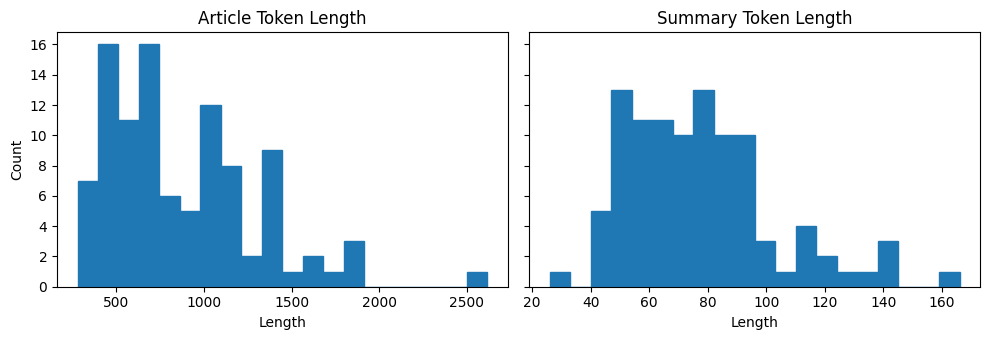

In [23]:
import matplotlib.pyplot as plt

# article과 highlights의 token 길이 계산
d_len = [len(tokenizer.encode(s)) for s in test_sampled["article"]]
s_len = [len(tokenizer.encode(s)) for s in test_sampled["highlights"]]

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)

axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Article Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")

plt.tight_layout()
plt.show()


In [25]:
def convert_examples_to_features(example_batch):
    # 기사(article) 입력 인코딩
    input_encodings = tokenizer(example_batch["article"], max_length=1024,
                                truncation=True)

    # 참조 요약(highlights) 인코딩
    target_encodings = tokenizer(text_target=example_batch["highlights"],
                                 max_length=128,
                                 truncation=True)

    return {
        "input_ids": input_encodings["input_ids"],
        "attention_mask": input_encodings["attention_mask"],
        "labels": target_encodings["input_ids"]
    }

# map 함수로 전체 전처리 적용 (batched=True로 성능 향상)
test_sampled_pt = test_sampled.map(convert_examples_to_features, batched=True)

# PyTorch 텐서 형식으로 변환
columns = ["input_ids", "labels", "attention_mask"]
test_sampled_pt.set_format(type="torch", columns=columns) # 모델 입력값으로 쓰기 위한 변환 


In [26]:
# 티처 포싱(teacher forcing)
# 텍스트 생성을 위한 디코더 입력과 레이블의 정렬
text = ['PAD','Transformers', 'are', 'awesome', 'for', 'text', 'summarization']
rows = []
for i in range(len(text)-1):
    rows.append({'step': i+1, 'decoder_input': text[:i+1], 'label': text[i+1]})
pd.DataFrame(rows).set_index('step')

,decoder_input,label
step,,
1,[PAD],Transformers
2,"[PAD, Transformers]",are
3,"[PAD, Transformers, are]",awesome
4,"[PAD, Transformers, are, awesome]",for
5,"[PAD, Transformers, are, awesome, for]",text
6,"[PAD, Transformers, are, awesome, for, text]",summarization


### 대화 요약 생성하기

## 결론